In [1]:
import sys
FOLDER_PATH = '/content/drive/MyDrive/Colab Notebooks/project/'
sys.path.append(FOLDER_PATH)

In [ ]:
!pip install -r drive/MyDrive/Colab\ Notebooks/project/requirements

In [3]:
import re
import imp
import time
import pickle

import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from pandarallel import pandarallel
from functools import partial

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from scipy import stats
from catboost import Pool, CatBoostClassifier

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

pandarallel.initialize(progress_bar=False)
# pd.set_option('display.max_colwidth', None)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# with open('{}catboost_model/stop_words.pickle'.format(FOLDER_PATH), 'wb') as f:
#   pickle.dump(stop_words, f)

In [5]:
def auc_group(df):
    y_hat = df['predict_catboost']
    y = df['is_bad']
    return roc_auc_score(y, y_hat)

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[tp, fp],
                   [fn, tn]])
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred) - 1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        # cm = cm.astype('float') / cm.sum()
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=np.arange(cm.shape[1])[::-1],
           yticklabels=np.arange(cm.shape[0])[::-1],
           title=title,
           ylabel='Predicted label',
           xlabel='True label')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
df_train = pd.read_csv('./drive/MyDrive/Colab Notebooks/project/_data/train_prep.csv', sep='|')
df_val = pd.read_csv('./drive/MyDrive/Colab Notebooks/project/_data/val_prep.csv', sep='|')
df_test = pd.read_csv('./drive/MyDrive/Colab Notebooks/project/_data/test_prep.csv', sep='|')

In [7]:
text_features = ['text']
cat_features = ['category', 'subcategory', 'region', 'month', 'hour']
num_features = ['price', 'num_words_count', 'digits_count', 
                'contact_words_count', 'tel_count', 'count_emoji']
bin_features = ['is_empty_price', 'is_full_phone', 'is_short_phone']

In [8]:
df_train['title_prep'] = df_train['title_prep'].astype('str')
df_train['description_prep'] = df_train['description_prep'].astype('str')
df_train['category'] = df_train['category'].astype('str')
df_train['subcategory'] = df_train['subcategory'].astype('str')
df_train['region'] = df_train['region'].astype('str')
df_train['month'] = df_train['month'].astype('str')
df_train['hour'] = df_train['hour'].astype('str')

df_val['title_prep'] = df_val['title_prep'].astype('str')
df_val['description_prep'] = df_val['description_prep'].astype('str')
df_val['category'] = df_val['category'].astype('str')
df_val['subcategory'] = df_val['subcategory'].astype('str')
df_val['region'] = df_val['region'].astype('str')
df_val['month'] = df_val['month'].astype('str')
df_val['hour'] = df_val['hour'].astype('str')

df_test['title_prep'] = df_test['title_prep'].astype('str')
df_test['description_prep'] = df_test['description_prep'].astype('str')
df_test['category'] = df_test['category'].astype('str')
df_test['subcategory'] = df_test['subcategory'].astype('str')
df_test['region'] = df_test['region'].astype('str')
df_test['month'] = df_test['month'].astype('str')
df_test['hour'] = df_test['hour'].astype('str')

In [9]:
df_train['text'] = df_train[['title_prep', 'description_prep']].agg(' '.join, axis=1)
df_val['text'] = df_val[['title_prep', 'description_prep']].agg(' '.join, axis=1)
df_test['text'] = df_test[['title_prep', 'description_prep']].agg(' '.join, axis=1)

In [10]:
X_train = df_train[text_features + cat_features + num_features + bin_features]
X_val = df_val[text_features + cat_features + num_features + bin_features]
X_test = df_test[text_features + cat_features + num_features + bin_features]

y_train = df_train['is_bad']
y_val = df_val['is_bad']
y_test = df_test['is_bad']

In [11]:
median_price = X_train.groupby('subcategory')['price'].median()

In [13]:
# with open('{}catboost_model/median_price.pickle'.format(FOLDER_PATH), 'wb') as f:
#   pickle.dump(median_price, f)

In [ ]:
X_train['price'] = X_train['price'].fillna(X_train['subcategory'].map(median_price))
X_val['price'] = X_val['price'].fillna(X_val['subcategory'].map(median_price))
X_test['price'] = X_test['price'].fillna(X_test['subcategory'].map(median_price))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train['price'].values.reshape(-1, 1))
X_train['price'] = scaler.transform(X_train['price'].values.reshape(-1, 1))
X_val['price'] = scaler.transform(X_val['price'].values.reshape(-1, 1))
X_test['price'] = scaler.transform(X_test['price'].values.reshape(-1, 1))

In [16]:
# with open('{}catboost_model/scaler.pickle'.format(FOLDER_PATH), 'wb') as f:
#   pickle.dump(scaler, f)

In [17]:
train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)
valid_pool = Pool(
    X_val, 
    y_val,
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)

test_pool = Pool(
    X_test, 
    y_test,
    cat_features=cat_features, 
    text_features=text_features, 
    feature_names=list(X_train)
)

In [18]:
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -4.6, 0),
    'iterations': hp.quniform('iterations', 200, 2000, 100),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 1),
    'depth': hp.quniform('depth', 8, 16, 1),
    'random_strength': hp.loguniform('random_strength', -20, 2.3),
    'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
    'border_count': hp.quniform('border_count', 1, 255, 1),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0), 
    }

In [19]:
def objective(params, train, valid):
    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        early_stopping_rounds=40,
        random_seed=42, 
        verbose=500,
        task_type='GPU',
        use_best_model=True
        # custom_metric='AUC:hints=skip_train~false'
        )
    model.set_params(**params)
    model.fit(train, eval_set=valid)
    return {
        'loss': model.get_best_score()['validation']['AUC'], 
        'status': STATUS_OK}

In [20]:
trials = Trials()
best = fmin( 
    fn=partial(objective, train=train_pool, valid=valid_pool),
    space=search_space,
    algo=tpe.suggest,
    max_evals=40,
    trials=trials,
    # rstate=np.random.RandomState(1),
    show_progressbar=True
    )

  0%|          | 0/40 [00:00<?, ?it/s, best loss: ?]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9434105	best: 0.9434105 (0)	total: 3.5s	remaining: 1h 56m 30s
500:	test: 0.9769993	best: 0.9769993 (500)	total: 29m 29s	remaining: 1h 28m 15s
1000:	test: 0.9791363	best: 0.9791363 (1000)	total: 58m 40s	remaining: 58m 33s
1500:	test: 0.9800272	best: 0.9800272 (1500)	total: 1h 27m 38s	remaining: 29m 8s
1999:	test: 0.9805651	best: 0.9805651 (1999)	total: 1h 56m 29s	remaining: 0us
bestTest = 0.9805650711
bestIteration = 1999
  2%|▎         | 1/40 [1:59:02<77:22:30, 7142.31s/it, best loss: 0.980565071105957]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9418997	best: 0.9418997 (0)	total: 492ms	remaining: 4m 54s
500:	test: 0.9788541	best: 0.9788541 (500)	total: 4m 2s	remaining: 47.9s
599:	test: 0.9792323	best: 0.9792323 (599)	total: 4m 49s	remaining: 0us
bestTest = 0.9792323112
bestIteration = 599
  5%|▌         | 2/40 [2:04:40<33:08:42, 3140.06s/it, best loss: 0.9792323112487793]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391988	best: 0.9391988 (0)	total: 930ms	remaining: 3m 5s
199:	test: 0.9765676	best: 0.9765676 (199)	total: 3m 4s	remaining: 0us
bestTest = 0.9765675664
bestIteration = 199
  8%|▊         | 3/40 [2:08:33<18:37:48, 1812.65s/it, best loss: 0.9765675663948059]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9419150	best: 0.9419150 (0)	total: 932ms	remaining: 13m 57s
bestTest = 0.9758170247
bestIteration = 195
Shrink model to first 196 iterations.
 10%|█         | 4/40 [2:12:58<12:01:01, 1201.71s/it, best loss: 0.9758170247077942]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9448365	best: 0.9448365 (0)	total: 509ms	remaining: 12m 43s
500:	test: 0.9718937	best: 0.9718937 (500)	total: 4m 10s	remaining: 8m 19s
1000:	test: 0.9756392	best: 0.9756392 (1000)	total: 8m 16s	remaining: 4m 7s
1499:	test: 0.9772885	best: 0.9772885 (1499)	total: 12m 18s	remaining: 0us
bestTest = 0.9772884846
bestIteration = 1499
 12%|█▎        | 5/40 [2:26:08<10:14:20, 1053.17s/it, best loss: 0.9758170247077942]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379916	best: 0.9379916 (0)	total: 281ms	remaining: 5m 36s
500:	test: 0.9746687	best: 0.9746687 (500)	total: 2m 15s	remaining: 3m 9s
1000:	test: 0.9768777	best: 0.9768777 (1000)	total: 4m 29s	remaining: 53.5s
1199:	test: 0.9774370	best: 0.9774370 (1199)	total: 5m 21s	remaining: 0us
bestTest = 0.9774370193
bestIteration = 1199
 15%|█▌        | 6/40 [2:32:19<7:45:19, 821.16s/it, best loss: 0.9758170247077942]  

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9409413	best: 0.9409413 (0)	total: 491ms	remaining: 8m 10s
500:	test: 0.9650856	best: 0.9650856 (500)	total: 4m 8s	remaining: 4m 7s
999:	test: 0.9704817	best: 0.9704817 (999)	total: 8m 16s	remaining: 0us
bestTest = 0.9704816639
bestIteration = 999
 18%|█▊        | 7/40 [2:41:26<6:42:22, 731.58s/it, best loss: 0.970481663942337] 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9314353	best: 0.9314353 (0)	total: 59.9ms	remaining: 29.9s
499:	test: 0.9713877	best: 0.9713877 (499)	total: 25.9s	remaining: 0us
bestTest = 0.9713876843
bestIteration = 499
 20%|██        | 8/40 [2:42:41<4:38:42, 522.59s/it, best loss: 0.970481663942337]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9197156	best: 0.9197156 (0)	total: 62.4ms	remaining: 49.8s
500:	test: 0.9537072	best: 0.9537072 (500)	total: 26.1s	remaining: 15.6s
799:	test: 0.9579163	best: 0.9579163 (799)	total: 42.1s	remaining: 0us
bestTest = 0.9579162598
bestIteration = 799
 22%|██▎       | 9/40 [2:44:13<3:20:23, 387.86s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9454561	best: 0.9454561 (0)	total: 928ms	remaining: 7m 43s
bestTest = 0.9769194722
bestIteration = 268
Shrink model to first 269 iterations.
 25%|██▌       | 10/40 [2:49:45<3:05:17, 370.60s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9483889	best: 0.9483889 (0)	total: 3.48s	remaining: 40m 32s
500:	test: 0.9698614	best: 0.9698614 (500)	total: 29m 30s	remaining: 11m 43s
699:	test: 0.9719936	best: 0.9719936 (699)	total: 41m 13s	remaining: 0us
bestTest = 0.9719936252
bestIteration = 699
 28%|██▊       | 11/40 [3:31:52<8:18:10, 1030.71s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9366961	best: 0.9366961 (0)	total: 82ms	remaining: 2m 27s
500:	test: 0.9672911	best: 0.9672911 (500)	total: 35.9s	remaining: 1m 32s
1000:	test: 0.9718265	best: 0.9718265 (1000)	total: 1m 10s	remaining: 56.1s
1500:	test: 0.9738673	best: 0.9738673 (1499)	total: 1m 43s	remaining: 20.6s
1799:	test: 0.9746700	best: 0.9746700 (1799)	total: 2m 2s	remaining: 0us
bestTest = 0.9746699929
bestIteration = 1799
 30%|███       | 12/40 [3:34:44<5:59:05, 769.47s/it, best loss: 0.957916259765625] 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9425771	best: 0.9425771 (0)	total: 285ms	remaining: 2m 50s
500:	test: 0.9795682	best: 0.9795703 (498)	total: 2m 13s	remaining: 26.3s
599:	test: 0.9798771	best: 0.9798771 (599)	total: 2m 38s	remaining: 0us
bestTest = 0.9798771143
bestIteration = 599
 32%|███▎      | 13/40 [3:38:13<4:29:46, 599.49s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9366986	best: 0.9366986 (0)	total: 77.7ms	remaining: 2m 19s
500:	test: 0.9736477	best: 0.9736477 (500)	total: 35s	remaining: 1m 30s
1000:	test: 0.9765339	best: 0.9765339 (1000)	total: 1m 7s	remaining: 53.9s
1500:	test: 0.9778019	best: 0.9778019 (1499)	total: 1m 39s	remaining: 19.9s
1799:	test: 0.9783683	best: 0.9783683 (1799)	total: 1m 59s	remaining: 0us
bestTest = 0.9783683419
bestIteration = 1799
 35%|███▌      | 14/40 [3:41:02<3:23:27, 469.53s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9223514	best: 0.9223514 (0)	total: 74.9ms	remaining: 2m 7s
500:	test: 0.9758846	best: 0.9758877 (499)	total: 31.5s	remaining: 1m 15s
1000:	test: 0.9772720	best: 0.9772720 (1000)	total: 1m 1s	remaining: 43.3s
1500:	test: 0.9779007	best: 0.9779192 (1486)	total: 1m 32s	remaining: 12.2s
1699:	test: 0.9780273	best: 0.9780289 (1696)	total: 1m 44s	remaining: 0us
bestTest = 0.9780288637
bestIteration = 1696
Shrink model to first 1697 iterations.
 38%|███▊      | 15/40 [3:43:36<2:36:00, 374.41s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9347061	best: 0.9347061 (0)	total: 1.79s	remaining: 11m 52s
399:	test: 0.9731399	best: 0.9731399 (399)	total: 11m 54s	remaining: 0us
bestTest = 0.9731399417
bestIteration = 399
 40%|████      | 16/40 [3:56:21<3:16:45, 491.88s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9415142	best: 0.9415142 (0)	total: 497ms	remaining: 4m 7s
499:	test: 0.9770347	best: 0.9770347 (499)	total: 4m 4s	remaining: 0us
bestTest = 0.9770347178
bestIteration = 499
 42%|████▎     | 17/40 [4:01:14<2:45:40, 432.19s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9476200	best: 0.9476200 (0)	total: 1.79s	remaining: 8m 54s
299:	test: 0.9757928	best: 0.9757928 (299)	total: 9m 1s	remaining: 0us
bestTest = 0.9757927656
bestIteration = 299
 45%|████▌     | 18/40 [4:11:05<2:55:59, 480.00s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9323623	best: 0.9323623 (0)	total: 278ms	remaining: 5m 5s
500:	test: 0.9586858	best: 0.9586858 (500)	total: 2m 14s	remaining: 2m 40s
1000:	test: 0.9636751	best: 0.9636751 (1000)	total: 4m 29s	remaining: 26.6s
1099:	test: 0.9643475	best: 0.9643475 (1099)	total: 4m 56s	remaining: 0us
bestTest = 0.9643475413
bestIteration = 1099
 48%|████▊     | 19/40 [4:16:50<2:33:49, 439.49s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9383276	best: 0.9383276 (0)	total: 175ms	remaining: 34.9s
199:	test: 0.9754753	best: 0.9754900 (198)	total: 30.8s	remaining: 0us
bestTest = 0.9754900038
bestIteration = 198
Shrink model to first 199 iterations.
 50%|█████     | 20/40 [4:18:10<1:50:30, 331.53s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9320306	best: 0.9320306 (0)	total: 167ms	remaining: 3m 37s
500:	test: 0.9621877	best: 0.9621877 (500)	total: 1m 18s	remaining: 2m 4s
1000:	test: 0.9656112	best: 0.9656116 (998)	total: 2m 35s	remaining: 46.5s
1299:	test: 0.9667017	best: 0.9667017 (1299)	total: 3m 21s	remaining: 0us
bestTest = 0.9667016864
bestIteration = 1299
 52%|█████▎    | 21/40 [4:22:22<1:37:21, 307.44s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9317195	best: 0.9317195 (0)	total: 170ms	remaining: 2m 15s
500:	test: 0.9662887	best: 0.9662887 (500)	total: 1m 20s	remaining: 48.1s
799:	test: 0.9687803	best: 0.9687803 (799)	total: 2m 7s	remaining: 0us
bestTest = 0.9687803388
bestIteration = 799
 55%|█████▌    | 22/40 [4:25:18<1:20:28, 268.25s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9303491	best: 0.9303491 (0)	total: 108ms	remaining: 1m 58s
500:	test: 0.9592177	best: 0.9592177 (500)	total: 49.1s	remaining: 58.7s
1000:	test: 0.9645590	best: 0.9645590 (1000)	total: 1m 37s	remaining: 9.68s
1099:	test: 0.9651212	best: 0.9651212 (1099)	total: 1m 47s	remaining: 0us
bestTest = 0.96512115
bestIteration = 1099
 57%|█████▊    | 23/40 [4:27:55<1:06:31, 234.77s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9095258	best: 0.9095258 (0)	total: 108ms	remaining: 2m 31s
500:	test: 0.9582452	best: 0.9582452 (500)	total: 50s	remaining: 1m 29s
1000:	test: 0.9617875	best: 0.9617875 (1000)	total: 1m 39s	remaining: 39.6s
1399:	test: 0.9633168	best: 0.9633168 (1399)	total: 2m 18s	remaining: 0us
bestTest = 0.9633167982
bestIteration = 1399
 60%|██████    | 24/40 [4:31:03<58:51, 220.74s/it, best loss: 0.957916259765625]  

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9071366	best: 0.9071366 (0)	total: 64.3ms	remaining: 1m 29s
500:	test: 0.9539073	best: 0.9539073 (500)	total: 25.6s	remaining: 46s
1000:	test: 0.9574935	best: 0.9574935 (1000)	total: 50.9s	remaining: 20.3s
1399:	test: 0.9591489	best: 0.9591520 (1392)	total: 1m 10s	remaining: 0us
bestTest = 0.9591520429
bestIteration = 1392
Shrink model to first 1393 iterations.
 62%|██████▎   | 25/40 [4:33:03<47:37, 190.50s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9197029	best: 0.9197029 (0)	total: 59.6ms	remaining: 1m 35s
500:	test: 0.9715612	best: 0.9715612 (500)	total: 25s	remaining: 54.8s
1000:	test: 0.9736475	best: 0.9736475 (1000)	total: 49.3s	remaining: 29.5s
1500:	test: 0.9748901	best: 0.9748901 (1500)	total: 1m 13s	remaining: 4.84s
1599:	test: 0.9750232	best: 0.9750232 (1599)	total: 1m 18s	remaining: 0us
bestTest = 0.9750231504
bestIteration = 1599
 65%|██████▌   | 26/40 [4:35:11<40:04, 171.74s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9314366	best: 0.9314366 (0)	total: 59ms	remaining: 1m 16s
500:	test: 0.9682668	best: 0.9682668 (500)	total: 26.3s	remaining: 42s
1000:	test: 0.9718913	best: 0.9718913 (1000)	total: 50.9s	remaining: 15.2s
1299:	test: 0.9729852	best: 0.9729852 (1299)	total: 1m 5s	remaining: 0us
bestTest = 0.972985208
bestIteration = 1299
 68%|██████▊   | 27/40 [4:37:06<33:30, 154.66s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9306150	best: 0.9306150 (0)	total: 115ms	remaining: 1m 43s
500:	test: 0.9640358	best: 0.9640358 (500)	total: 51.7s	remaining: 41.2s
899:	test: 0.9681550	best: 0.9681550 (899)	total: 1m 32s	remaining: 0us
bestTest = 0.9681549668
bestIteration = 899
 70%|███████   | 28/40 [4:39:28<30:10, 150.91s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9358333	best: 0.9358333 (0)	total: 83.4ms	remaining: 2m 46s
500:	test: 0.9585958	best: 0.9585958 (500)	total: 36.2s	remaining: 1m 48s
1000:	test: 0.9647441	best: 0.9647441 (1000)	total: 1m 11s	remaining: 1m 11s
1500:	test: 0.9678430	best: 0.9678430 (1500)	total: 1m 47s	remaining: 35.6s
1999:	test: 0.9696291	best: 0.9696291 (1999)	total: 2m 21s	remaining: 0us
bestTest = 0.9696291089
bestIteration = 1999
 72%|███████▎  | 29/40 [4:42:39<29:52, 162.97s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9261932	best: 0.9261932 (0)	total: 64.6ms	remaining: 1m 36s
500:	test: 0.9595510	best: 0.9595510 (500)	total: 26.2s	remaining: 52.3s
1000:	test: 0.9645836	best: 0.9645836 (1000)	total: 52.2s	remaining: 26s
1499:	test: 0.9669714	best: 0.9669714 (1499)	total: 1m 17s	remaining: 0us
bestTest = 0.9669713676
bestIteration = 1499
 75%|███████▌  | 30/40 [4:44:46<25:21, 152.16s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9341957	best: 0.9341957 (0)	total: 113ms	remaining: 3m 46s
500:	test: 0.9707058	best: 0.9707058 (500)	total: 51.2s	remaining: 2m 33s
1000:	test: 0.9736724	best: 0.9736724 (1000)	total: 1m 39s	remaining: 1m 39s
1500:	test: 0.9751272	best: 0.9751272 (1500)	total: 2m 26s	remaining: 48.7s
1999:	test: 0.9760841	best: 0.9760841 (1999)	total: 3m 13s	remaining: 0us
bestTest = 0.9760840535
bestIteration = 1999
 78%|███████▊  | 31/40 [4:48:49<26:54, 179.43s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9300846	best: 0.9300846 (0)	total: 81.2ms	remaining: 1m 4s
500:	test: 0.9735210	best: 0.9735210 (500)	total: 33.8s	remaining: 20.2s
799:	test: 0.9750854	best: 0.9750854 (799)	total: 53.1s	remaining: 0us
bestTest = 0.9750853777
bestIteration = 799
 80%|████████  | 32/40 [4:50:31<20:50, 156.31s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9262022	best: 0.9262022 (0)	total: 65.4ms	remaining: 1m 5s
500:	test: 0.9550788	best: 0.9550788 (500)	total: 25.8s	remaining: 25.7s
999:	test: 0.9604829	best: 0.9604829 (999)	total: 51.6s	remaining: 0us
bestTest = 0.9604829252
bestIteration = 999
 82%|████████▎ | 33/40 [4:52:13<16:18, 139.77s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9397306	best: 0.9397306 (0)	total: 176ms	remaining: 3m 48s
500:	test: 0.9714428	best: 0.9714428 (500)	total: 1m 21s	remaining: 2m 9s
1000:	test: 0.9750521	best: 0.9750521 (1000)	total: 2m 39s	remaining: 47.7s
1299:	test: 0.9761465	best: 0.9761465 (1299)	total: 3m 25s	remaining: 0us
bestTest = 0.9761464596
bestIteration = 1299
 85%|████████▌ | 34/40 [4:56:28<17:27, 174.55s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9318769	best: 0.9318769 (0)	total: 80ms	remaining: 1m 35s
500:	test: 0.9751621	best: 0.9751621 (500)	total: 33.3s	remaining: 46.4s
1000:	test: 0.9768740	best: 0.9768740 (1000)	total: 1m 4s	remaining: 12.9s
1199:	test: 0.9772983	best: 0.9772983 (1199)	total: 1m 17s	remaining: 0us
bestTest = 0.9772983193
bestIteration = 1199
 88%|████████▊ | 35/40 [4:58:35<13:21, 160.26s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9292645	best: 0.9292645 (0)	total: 59.3ms	remaining: 1m 28s
500:	test: 0.9549870	best: 0.9549870 (500)	total: 26.9s	remaining: 53.6s
1000:	test: 0.9610207	best: 0.9610207 (1000)	total: 55.5s	remaining: 27.7s
1499:	test: 0.9641455	best: 0.9641455 (1499)	total: 1m 22s	remaining: 0us
bestTest = 0.9641454816
bestIteration = 1499
 90%|█████████ | 36/40 [5:00:48<10:07, 151.91s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9101043	best: 0.9101043 (0)	total: 112ms	remaining: 1m 41s
500:	test: 0.9633206	best: 0.9633206 (500)	total: 49.4s	remaining: 39.4s
899:	test: 0.9658386	best: 0.9658388 (898)	total: 1m 28s	remaining: 0us
bestTest = 0.9658387899
bestIteration = 898
Shrink model to first 899 iterations.
 92%|█████████▎| 37/40 [5:03:05<07:22, 147.45s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9308907	best: 0.9308907 (0)	total: 62.2ms	remaining: 43.5s
500:	test: 0.9626296	best: 0.9626296 (500)	total: 26.8s	remaining: 10.6s
699:	test: 0.9652378	best: 0.9652378 (699)	total: 37.3s	remaining: 0us
bestTest = 0.9652378261
bestIteration = 699
 95%|█████████▌| 38/40 [5:04:31<04:18, 129.15s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9298729	best: 0.9298729 (0)	total: 81.7ms	remaining: 1m 21s
500:	test: 0.9727520	best: 0.9727520 (500)	total: 33.5s	remaining: 33.3s
999:	test: 0.9753301	best: 0.9753301 (999)	total: 1m 5s	remaining: 0us
bestTest = 0.9753301442
bestIteration = 999
 98%|█████████▊| 39/40 [5:06:26<02:04, 124.82s/it, best loss: 0.957916259765625]

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9448201	best: 0.9448201 (0)	total: 935ms	remaining: 18m 40s
500:	test: 0.9776214	best: 0.9776214 (500)	total: 7m 45s	remaining: 10m 49s
1000:	test: 0.9798368	best: 0.9798368 (1000)	total: 15m 24s	remaining: 3m 3s
1199:	test: 0.9803185	best: 0.9803185 (1199)	total: 18m 27s	remaining: 0us
bestTest = 0.9803185463
bestIteration = 1199
100%|██████████| 40/40 [5:25:44<00:00, 488.62s/it, best loss: 0.957916259765625]


In [21]:
hyperparams = space_eval(search_space, best)

In [22]:
hyperparams

{'bagging_temperature': 0.8074362145359162,
 'border_count': 194.0,
 'depth': 8.0,
 'iterations': 800.0,
 'l2_leaf_reg': 4.0,
 'learning_rate': 0.010526980177211025,
 'random_strength': 7.779948217677066e-08,
 'scale_pos_weight': 0.13883240665912344}

In [ ]:
params = {'learning_rate' : hyperparams['learning_rate'],
          'iterations' : hyperparams['iterations'],
          'l2_leaf_reg' : hyperparams['l2_leaf_reg'],
          'depth' : hyperparams['depth'],
          'random_strength' : hyperparams['random_strength'],
          'bagging_temperature' : hyperparams['bagging_temperature'],
          'border_count' : hyperparams['border_count'],
          'scale_pos_weight' : hyperparams['scale_pos_weight'],
          'eval_metric' : 'AUC',
          'loss_function' : 'Logloss',
          # 'early_stopping_rounds': 100,
          'random_seed': 42, 
          'verbose': 500,
          'task_type': 'GPU',
          'custom_metric' : 'AUC:hints=skip_train~false'
          }

In [ ]:
params = {
  'iterations':1500,
  'bagging_temperature':0.013913309445571221,
  'learning_rate':0.0967568116501488,
  'random_strength':6.9228120036506437,
  'depth':13,
  'l2_leaf_reg':4.972775259508048,
  'eval_metric' : 'AUC',
  'loss_function' : 'Logloss',
  'random_seed': 42, 
  'verbose': 500,
  'task_type': 'GPU',
  'custom_metric' : 'AUC:hints=skip_train~false'
}

In [ ]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=valid_pool)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9400443	best: 0.9400443 (0)	total: 598ms	remaining: 14m 56s
500:	test: 0.9791456	best: 0.9791456 (500)	total: 4m 23s	remaining: 8m 45s
1000:	test: 0.9809176	best: 0.9809176 (1000)	total: 8m 34s	remaining: 4m 16s
1499:	test: 0.9815833	best: 0.9815845 (1495)	total: 12m 44s	remaining: 0us
bestTest = 0.981584549
bestIteration = 1495
Shrink model to first 1496 iterations.


In [ ]:
model.get_params()

{'bagging_temperature': 0.013913309445571221,
 'custom_metric': 'AUC:hints=skip_train~false',
 'depth': 13,
 'eval_metric': 'AUC',
 'iterations': 1500,
 'l2_leaf_reg': 4.972775259508048,
 'learning_rate': 0.0967568116501488,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'random_strength': 6.922812003650644,
 'task_type': 'GPU',
 'verbose': 500}

In [ ]:
# model.save_model('{}/catboost_model/catboost_model.cbm'.format(FOLDER_PATH))

In [8]:
catboost = CatBoostClassifier().load_model('{}/catboost_model/catboost_model.cbm'.format(FOLDER_PATH))

In [ ]:
print('TRAIN')
print(roc_auc_score(df_train['is_bad'], df_train['predict_catboost']))
print(df_train.groupby(['category']).apply(auc_group))
print(df_train.groupby(['category']).apply(auc_group).mean())
print('=' * 20)

print('VAL')
print(roc_auc_score(df_val['is_bad'], df_val['predict_catboost']))
print(df_val.groupby(['category']).apply(auc_group))
print(df_val.groupby(['category']).apply(auc_group).mean())
print('=' * 20)

print('TEST')
print(roc_auc_score(df_test['is_bad'], df_test['predict_catboost']))
print(df_test.groupby(['category']).apply(auc_group))
print(df_test.groupby(['category']).apply(auc_group).mean())
print('=' * 20)

result_auc = pd.concat([
           df_train.groupby(['category']).apply(auc_group), 
           df_val.groupby(['category']).apply(auc_group), 
           df_test.groupby(['category']).apply(auc_group)], 
          axis=1)
result_auc.columns = ['train', 'val', 'test']
display(result_auc)

TRAIN
0.9923827796802641
category
Бытовая электроника    0.990618
Для бизнеса            0.985977
Для дома и дачи        0.986557
Животные               0.995747
Личные вещи            0.989375
Недвижимость           0.995266
Работа                 0.985069
Транспорт              0.995290
Услуги                 0.990127
Хобби и отдых          0.986151
dtype: float64
0.9900178651069436
VAL
0.981584474094459
category
Бытовая электроника    0.970843
Для бизнеса            0.915740
Для дома и дачи        0.971851
Животные               0.989260
Личные вещи            0.978630
Недвижимость           0.985628
Работа                 0.944833
Транспорт              0.989781
Услуги                 0.971115
Хобби и отдых          0.967431
dtype: float64
0.9685113355225262
TEST
0.9673643589688095
category
Бытовая электроника    0.947841
Для бизнеса            0.901929
Для дома и дачи        0.946905
Животные               0.946395
Личные вещи            0.837132
Недвижимость           0.962911
Ра

,train,val,test
category,,,
Бытовая электроника,0.990618,0.970843,0.947841
Для бизнеса,0.985977,0.915740,0.901929
Для дома и дачи,0.986557,0.971851,0.946905
Животные,0.995747,0.989260,0.946395
Личные вещи,0.989375,0.978630,0.837132
Недвижимость,0.995266,0.985628,0.962911
Работа,0.985069,0.944833,0.919032
Транспорт,0.995290,0.989781,0.991128
Услуги,0.990127,0.971115,0.892973


In [ ]:
df_train[['id', 'predict_catboost']].to_csv(
    '{}/catboost_scores/X_train.csv'.format(FOLDER_PATH), 
    sep='|')
df_val[['id', 'predict_catboost']].to_csv(
    '{}/catboost_scores/X_val.csv'.format(FOLDER_PATH), 
    sep='|')
df_test[['id', 'predict_catboost']].to_csv(
    '{}/catboost_scores/X_test.csv'.format(FOLDER_PATH), 
    sep='|')

# pd.read_csv('{}/catboost_scores/X_train.csv'.format(FOLDER_PATH), sep='|', index_col=0)

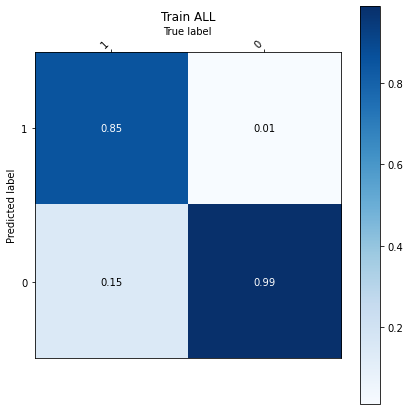

In [ ]:
plot_confusion_matrix(
    X_train['is_bad'], 
    np.where(X_train['predict_catboost'] > 0.5, 1, 0), 
    normalize=True, 
    title='Train ALL');

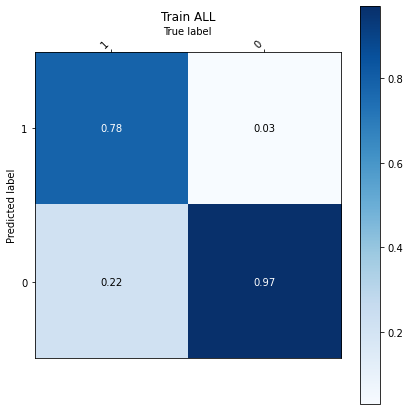

In [ ]:
plot_confusion_matrix(
    X_test['is_bad'], 
    np.where(X_test['pred'] > 0.5, 1, 0), 
    normalize=True, 
    title='Train ALL');

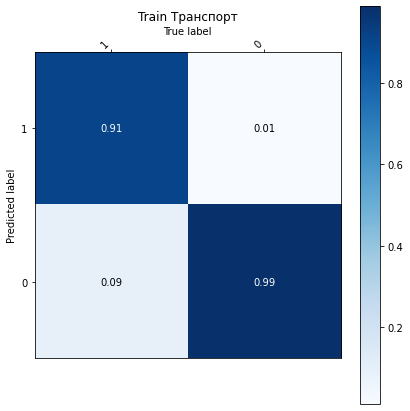

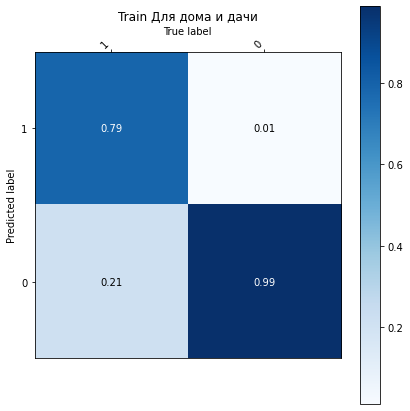

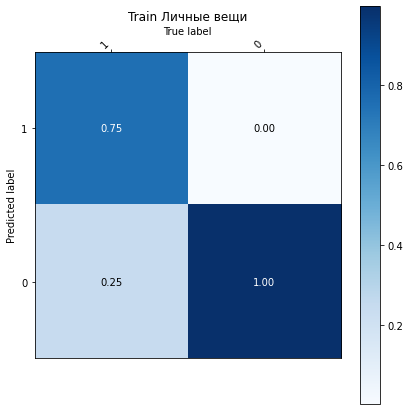

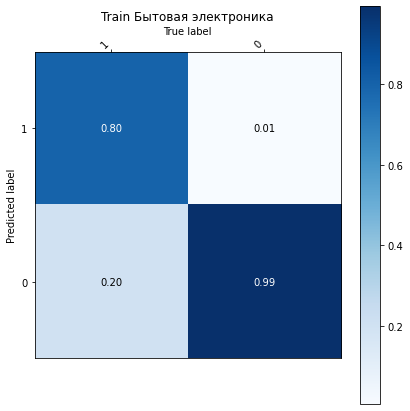

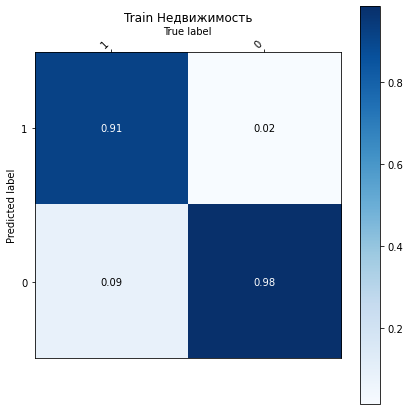

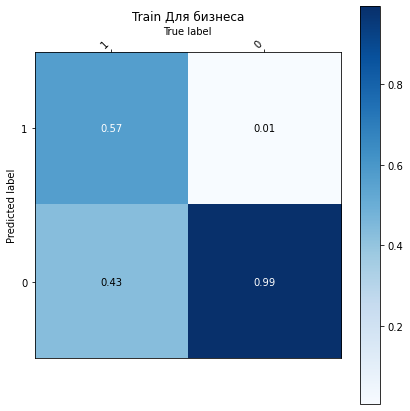

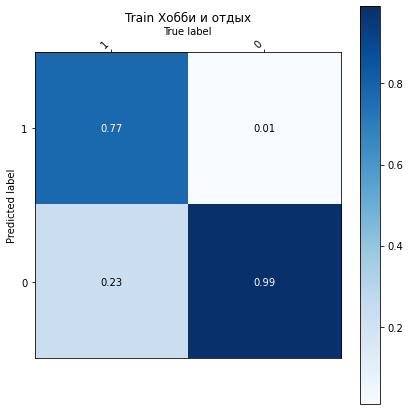

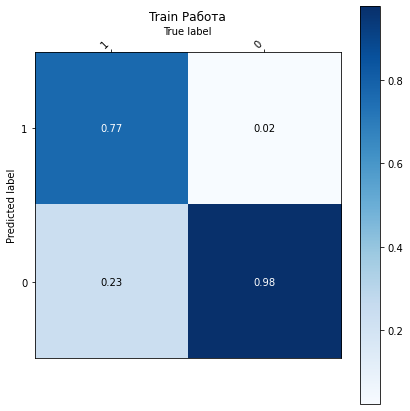

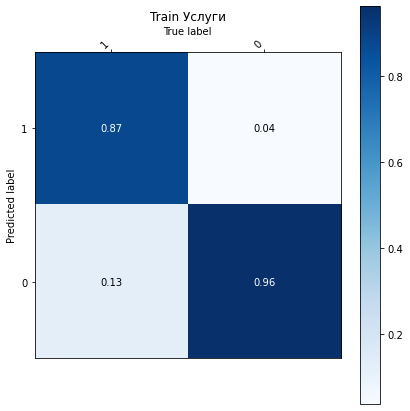

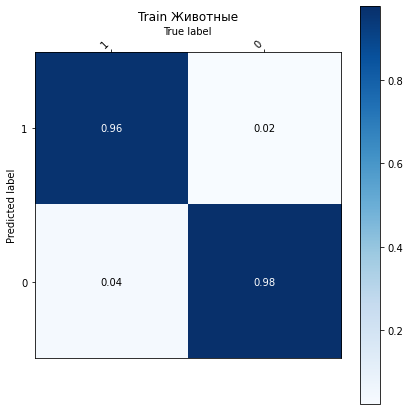

In [ ]:
for cat in X_train['category'].unique():
    ytrue = X_train[X_train['category'] == cat]['is_bad']
    yhat = X_train[X_train['category'] == cat]['pred']
    plot_confusion_matrix(
        ytrue, 
        np.where(yhat > 0.5, 1, 0), 
        normalize=True, 
        title='Train {}'.format(cat));

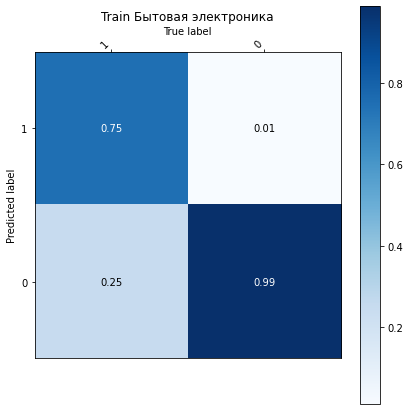

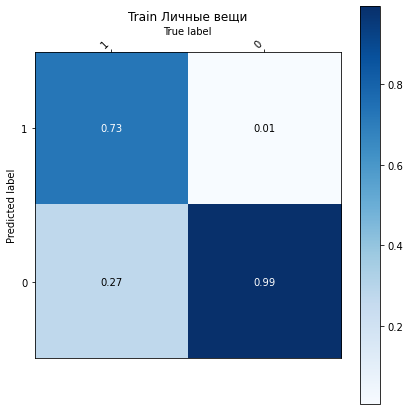

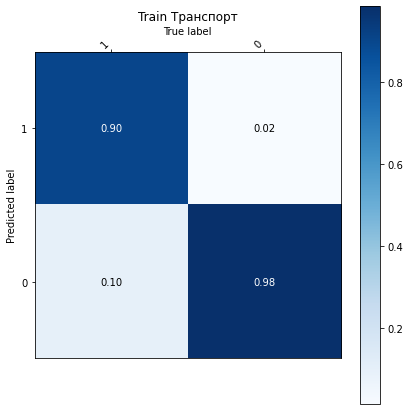

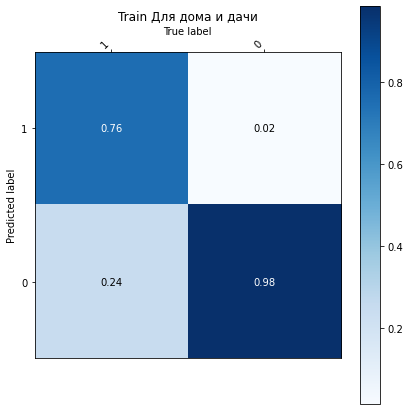

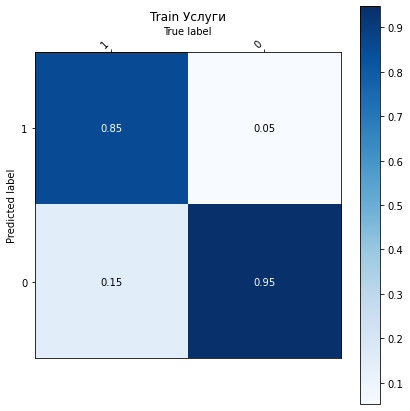

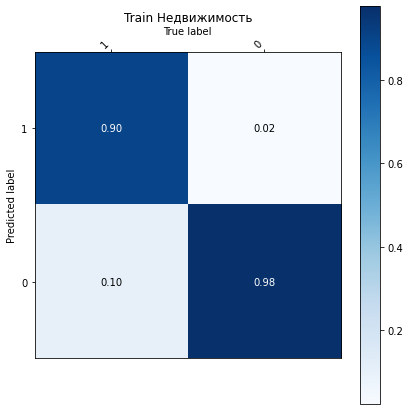

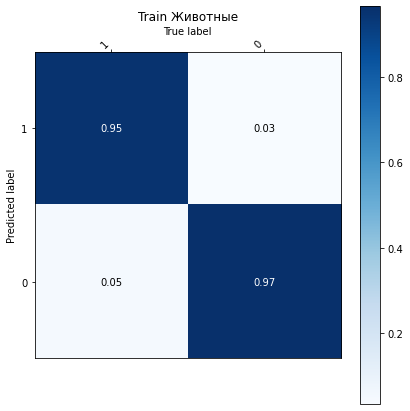

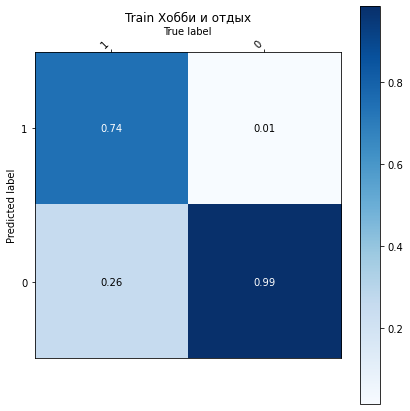

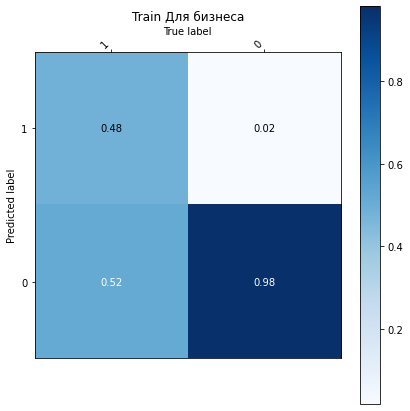

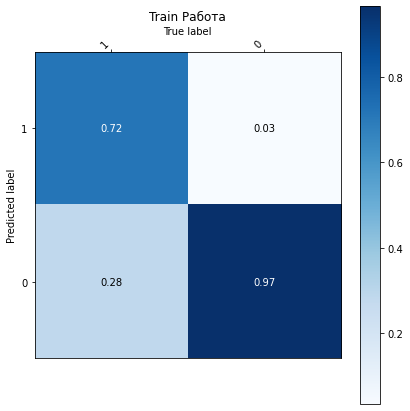

In [ ]:
for cat in X_val['category'].unique():
    ytrue = X_val[X_val['category'] == cat]['is_bad']
    yhat = X_val[X_val['category'] == cat]['pred']
    plot_confusion_matrix(
        ytrue, 
        np.where(yhat > 0.5, 1, 0), 
        normalize=True, 
        title='Train {}'.format(cat));

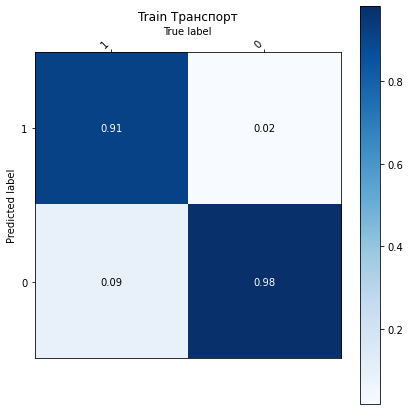

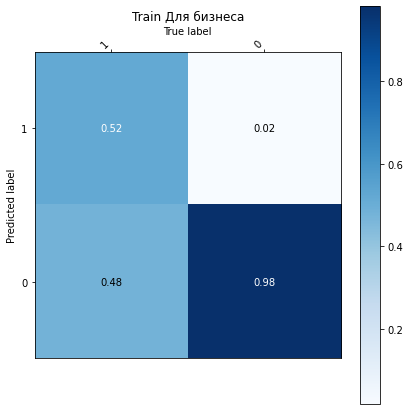

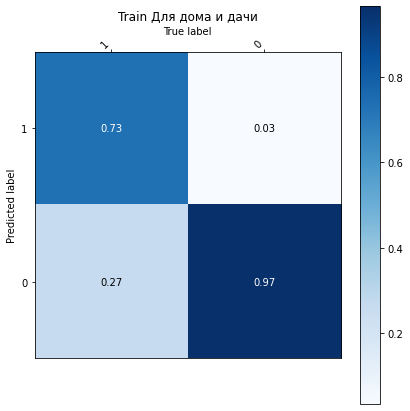

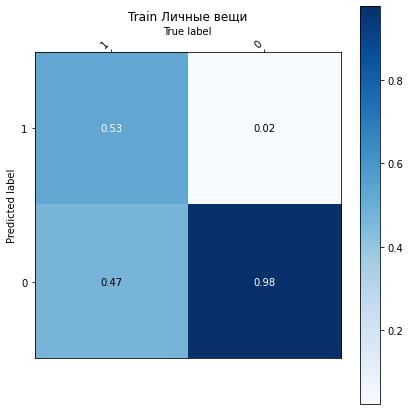

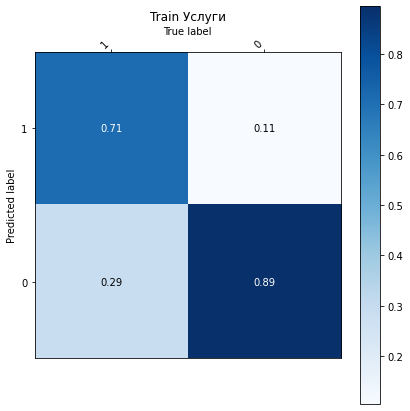

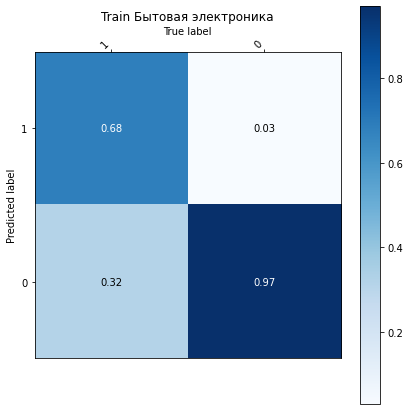

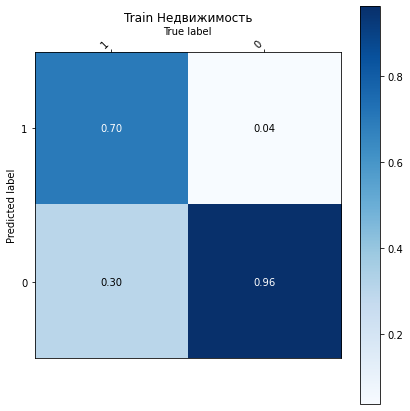

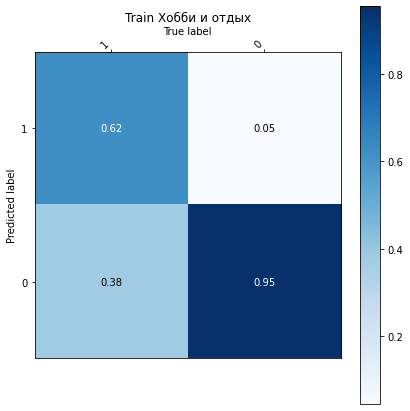

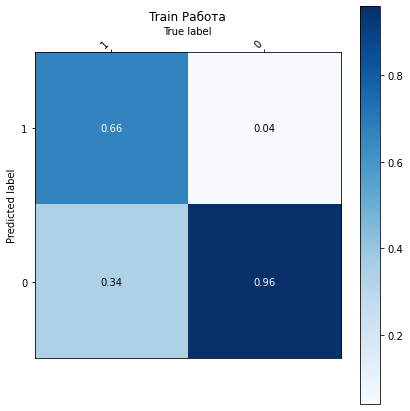

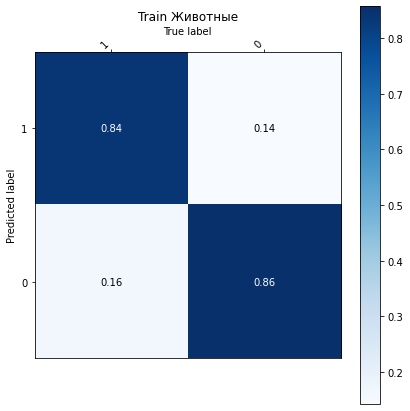

In [ ]:
for cat in X_test['category'].unique():
    ytrue = X_test[X_test['category'] == cat]['is_bad']
    yhat = X_test[X_test['category'] == cat]['pred']
    plot_confusion_matrix(
        ytrue, 
        np.where(yhat > 0.5, 1, 0), 
        normalize=True, 
        title='Train {}'.format(cat));

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/Colab Notebooks/aviprojectto/_data/val.csv')

In [ ]:
t1 = X_test[
       (X_test['category'] == 'Личные вещи') & 
       ((X_test['is_bad'] == 1) & (np.where(X_test['pred'] > 0.5, 1, 0) == 0))
       ][['text', 'num_words_count', 'digits_count', 'contact_words_count', 'tel_count',
       'is_empty_price', 'is_full_phone', 'is_short_phone', 'pred', 'is_bad']]

In [ ]:
merged_test = t1.merge(
    df_test[['title', 'description']], 
    left_index=True, 
    right_index=True)
merged_test[['title', 'description', 'num_words_count', 
             'digits_count', 'contact_words_count', 'tel_count',
             'is_empty_price', 'is_full_phone', 'is_short_phone', 
             'pred', 'is_bad']]

,title,description,num_words_count,digits_count,contact_words_count,tel_count,is_empty_price,is_full_phone,is_short_phone,pred,is_bad
423,Коляска,Коляска в очень хорошем состоянии Татьяна 9244648575,0,10,0,0,0,1,1,0.295324,1
435,Ходунки,Продам ходунки в отличном состоянии Татьяна Сергеевна 9122328474,0,10,0,0,0,1,1,0.216549,1
956,Платье,Платье ни разу не носилось в отличном состоянии! Светлана 9415830477,0,10,0,0,0,1,1,0.403225,1
1390,Платье для девочки,"Два совершенно новых платья ,пропустили размер. Цена за два платья/\nТелефон 934 651 20 13",2,10,1,1,0,1,1,0.101237,1
1427,Костюм,Продам костюм на весну. Флисовая подкладка. Р-р 94 (4 года). Возможна доставка. /\nЗвонить/писать на мтс5231002,0,10,1,0,0,1,1,0.109733,1
1454,Блузка Gabriela,Яркая повседневная блузка отлично разнообразит ваш гардероб. Модель насыщенного ягодного цвета декорирована принтом в мелкий белый горох. Застёжка на пуговицы расположена спереди. Изделие дополнено рукавами универсальной длины ¾ и классическим отложным воротником. По бокам имеются разрезы. Ну груди блузки есть два небольших кармашка с клапанами. Такая модель хорошо дополняет образы в стиле casual.,1,0,0,0,0,0,0,0.006179,1
1455,Платье Gabriela,"Яркое длинное платье свободного кроя красного цвета внесёт разнообразие в ваш гардероб. Модель отрезная по линии груди. Изделие дополнено округлым вырезом горловины, прорезными карманами по бокам и рукавами универсальной длины до локтя. Благодаря разрезам, расположенным по бокам изделия, платье не сковывает ваших движений во время ходьбы. Спинка модели украшена декоративной сборкой по линии талии. Вискоза, входящая в состав ткани платья, делает его мягким и комфортным.",0,0,0,0,0,0,0,0.007408,1
1456,Платье Gabriela,"Оригинальное длинное платье цвета электрик эффектно разнообразит ваш гардероб. Изделие отрезное по линии груди. Модель дополнена прорезными карманами по бокам, рукавами удобной длины до локтя и округлым вырезом горловины. По бокам имеются удобные разрезы, благодаря которым платье не сковывает ваших движений при ходьбе. На спинке платья есть декоративная сборка по линии талии. Вискоза в составе ткани делает платье мягким и комфортным.",0,0,0,0,0,0,0,0.007398,1
1510,Качели на цепочках для детской площадки,"Покрытые порошковыми красками металлические элементы, оцинкованный крепеж/\n /\nНаша компания ООО «Эльбрус реал эстэйт» занимается продажей и установкой оборудования для детских и спортивных площадок в Сочи и Краснодарском крае, а также укладкой резинового покрытия из EPDM крошки на детских и спортивных площадках./\n /\nМы являемся официальными дилерами заводов, что дает нам возможность предложить минимальную цену на оборудование. Также осуществляем полный комплекс работ под ключ от проектирования площадки и подготовки основания, до поставки и установки оборудования:/\n /\nНеобходимо сделать площадку, но не знаете как она будет выглядеть? Для каждого клиента мы предлагаем бесплатную услугу 5-D визуализации будущей площадки с выбранным оборудованием./\n /\nОставьте заявку на сайте или по телефону +7 (843) 336-75-16 и мы подберем вам оборудование, сделаем бесплатную 5-D визуализацию площадки и рассчитаем стоимость площадки под ключ.",0,13,1,1,0,0,1,0.340173,1
1760,Профессиональные фартуки,"Продам профессиональные фартуки для салонов красоты, салонов цветов, ресторанов и кафе! Возможно изготовление под заказ с фирменным логотипом салона, лазерная гравировка, вышивка, индивидуальные размеры, разнообразные ткани и модели! Срок изготовления от 5 до 3 дней! Быстро и качественно! Цена фартука с подкладом и деталями из натуральной кожи в среднем составляет 2300 руб. Базовые Модели фартуков с кожаными ремнями от 1900 руб. Больше наших работ можно посмотреть на странице greygoose.pro в ИГ и на нашем сайте greygoose.pro",0,10,2,0,0,0,1,0.335715,1
